In [32]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import SpectralClustering, KMeans
import tkinter
import numpy.matlib
np.set_printoptions(suppress=True)
from numpy import linalg as LA
import scipy.sparse as sp
import pywt
import tensorflow as tf
import tensorflow_probability as tfp
import pywt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.manifold import LocallyLinearEmbedding, SpectralEmbedding
from sklearn import mixture
import pandas as pd
import matplotlib

In [113]:
data = pd.read_csv("moon_data.csv")
data = data.to_numpy()
data

label = pd.read_csv("moon_label.csv")
label = label.to_numpy().T

In [114]:
data

array([[ 1.90961536, -0.27936506],
       [ 0.92222609, -0.0979144 ],
       [ 2.01120641, -0.23379265],
       ...,
       [-0.01170119,  0.13036632],
       [ 0.81873896,  0.05276338],
       [-0.82075066,  0.68039911]])

In [115]:
from sklearn import cluster, datasets

In [116]:
label.shape

(1, 1600)

In [87]:
noisy_moons = datasets.make_moons(n_samples=1500, noise=.05)
noisy_moons

(array([[ 1.63099921, -0.25005706],
        [ 1.96729401,  0.18022856],
        [-0.85430003,  0.41940083],
        ...,
        [ 1.61642325, -0.14507827],
        [ 0.69099116,  0.76719608],
        [ 0.18520038,  0.04716729]]),
 array([1, 1, 0, ..., 1, 0, 1]))

# original RNE

In [26]:
def find_neighbors(X, n_neighbors=6):
    """
    Compute the square distance matrix using Euclidean distance
    :param X: Input data, a numpy array of shape (n, d)
    :param n_neighbors: Number of nearest neighbors to consider, int
    :return: numpy array of shape (n, n_neighbors), numpy array of shape (n, n_neighbors)
    """
    def dist(a, b):
        return np.sqrt(sum((a - b)**2))

    # Compute full distance matrix (n , n)
    distances = np.array([[dist(p1, p2) for p2 in X] for p1 in X])

    # by default, Keep only the 6 nearest neighbors, others set to 0 (= unreachable)
    neighbor_idx = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]

    return neighbor_idx


def weight_LLE(data, n_neighbors=6):
    n = data.shape[0]
    # Compute the nearest neighbors
    print("finding ",n_neighbors," neighbors for ",n," data")
    neighbors_idx = find_neighbors(data, n_neighbors)

    w = np.zeros((n, n))

    #print("calculating weights")
    for i in range(n):
        # Center the neighbors matrix
        k_indexes = neighbors_idx[i, :]
        neighbors = data[k_indexes, :] - data[i, :]

        # Compute the corresponding gram matrix
        gram_inv = np.linalg.pinv(np.dot(neighbors, neighbors.T))

        # Setting the weight values according to the lagrangian
        lambda_par = 2/np.sum(gram_inv)
        w[i, k_indexes] = lambda_par*np.sum(gram_inv, axis=1)/2

        #if i%(np.int(n/10)) == 0:
        #    print(i/np.int(n/10)*10,"%")

    return w




In [27]:
def robust_neighbor_embedding(X, n_neighbors, out_dim, tol=1e-6, max_iter=200):
    
    # LLE's weight matrix
    W = weight_LLE(X,n_neighbors)
    

    n,d = X.shape
    H = np.random.rand(d,out_dim).round(4)
    ## W
    
    # M = (I-W)' (I-W)
    #A = eye(*W.shape, format=W.format) - W
    #A = (A.T).dot(A).tocsr()
    A = np.dot((np.eye(n) - np.transpose(W)), X)    
    AA = np.dot(A.T,A) #.tocsr()
    AAplus = 0.5 * (np.abs(AA) + AA)
    AAsubtract = 0.5 * (np.abs(AA) - AA)
    
    #initialize H, Y, alpha, gamma, gamma_max, mu
    M = np.dot(A, H)
    Y = np.zeros((n,out_dim))
    mu = 1.1
    gamma = 10
    max_gamma = 10000000000.0
    alpha = 1000.0
    iter_num = 100
    iter_numH = 100

    eps = 0.0001

    for j in np.arange(1, iter_num+1):
        AM = np.dot(np.transpose(A), M)
        AY = np.dot(np.transpose(A), Y)
        AMplus = 0.5 * (np.abs(AM) + AM)
        AMsubtract = 0.5 * (np.abs(AM) - AM)
        AYplus = 0.5 * (np.abs(AY) + AY)
        AYsubtract = 0.5 * (np.abs(AY) - AY)

        #update H
        for i in np.arange(1, iter_numH+1):

            G1 = np.diag(np.sqrt(1.0 / np.diag(np.dot(np.transpose(H), H)) + eps)).round(4)
            #print("G1", G1)
            H = np.dot(H, G1)
            a = (np.dot((alpha * H ), np.dot(np.transpose(H), H))+gamma * AMsubtract + gamma * np.dot(AAplus,H)+ AYsubtract + eps)
            c = ((alpha * H) + (gamma * AMplus) + np.dot(gamma*AAsubtract, H) + AYplus)
            H = H * np.sqrt(c/a)        
        
        # Update M
        temp = np.dot(A,H)-Y/gamma
        M = pywt.threshold(temp,1/gamma, mode='soft')

        # Update Y
        Y = Y + gamma*(M-np.dot(A,H)).round(4)
        
        # Update gamma
        gamma = min(mu*gamma,max_gamma)

    index_amplitude = np.sum(H*H,axis=1) #contribution of each feature 1~d
    ranking = np.argsort(-index_amplitude) #biggest first
    selected_index = ranking[0:out_dim] #select 1~out_dim

    X_rne = X[:,selected_index]


    return X_rne #, selected_index, H

# Modified RNE version 1

In [28]:
def robust_neighbor_embedding_modified(X, n_neighbors, out_dim, tol=1e-6, max_iter=200):
    
    # LLE's weight matrix
    #W = weight_LLE(X, n_neighbors)
    se = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=se_nbrs)
    W = se.fit_transform(data)
#     se = SpectralEmbedding(n_components=X, affinity='nearest_neighbors', n_neighbors=se_nbrs)
#     W = se.fit_transform(X)
#     W
    
    #W = SpectralEmbedding(X, n_neighbors)
    n,d = X.shape
    H = np.random.rand(d,out_dim)
    ## W
    
    # M = (I-W)' (I-W)
    #A = eye(*W.shape, format=W.format) - W
    #A = (A.T).dot(A).tocsr()
    A = np.dot((np.eye(n) - np.transpose(W[:,None])), X)  
    A = A[1,:,:].reshape(n,d)
    AA = np.dot(np.transpose(A),A) #.tocsr()
    AAplus = 0.5 * (np.abs(AA) + AA)
    AAsubtract = 0.5 * (np.abs(AA) - AA)
    
    #initialize H, Y, alpha, gamma, gamma_max, mu
    M = np.dot(A, H)
    Y = np.zeros((n,out_dim))
    mu = 1.1
    gamma = 10
    max_gamma = 10000000000.0
    alpha = 1000.0
    iter_num = 100
    iter_numH = 100

    eps = 0.0001

    for j in np.arange(1, iter_num+1):
        AM = np.dot(np.transpose(A), M)
        AY = np.dot(np.transpose(A), Y)
        AMplus = 0.5 * (np.abs(AM) + AM)
        AMsubtract = 0.5 * (np.abs(AM) - AM)
        AYplus = 0.5 * (np.abs(AY) + AY)
        AYsubtract = 0.5 * (np.abs(AY) - AY)

        #update H
        for i in np.arange(1, iter_numH+1):

            G1 = np.diag(np.sqrt(1.0 / np.diag(np.dot(np.transpose(H), H)) + eps))
            #print("G1", G1)
            H = np.dot(H, G1)
            a = (np.dot((alpha * H ), np.dot(np.transpose(H), H))+gamma * AMsubtract + gamma * np.dot(AAplus,H)+ AYsubtract + eps)
            c = ((alpha * H) + (gamma * AMplus) + np.dot(gamma*AAsubtract, H) + AYplus)
            H = H * np.sqrt(c/a)        
        
        # Update M
        temp = np.dot(A,H)-Y/gamma
        M = pywt.threshold(temp,1/gamma, mode='soft')

        # Update Y
        Y = Y + gamma*(M-np.dot(A,H))
        
        # Update gamma
        gamma = min(mu*gamma,max_gamma)

    index_amplitude = np.sum(H*H,axis=1) #contribution of each feature 1~d
    ranking = np.argsort(-index_amplitude) #biggest first
    selected_index = ranking[0:out_dim] #select 1~out_dim

    X_rne = X[:,selected_index]


    return X_rne #,selected_index, H

# Modified RNE version 2

In [29]:
def robust_neighbor_embedding_modified_2(X, n_neighbors, out_dim, tol=1e-6, max_iter=200):


    X = data
    n_neighbors = 45
    out_dim = 2 
    tol=1e-6
    max_iter=200
    
    # LLE's weight matrix
    W = weight_LLE(X, n_neighbors)
    #se = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=se_nbrs)
    #W = se.fit_transform(data)
#     se = SpectralEmbedding(n_components=X, affinity='nearest_neighbors', n_neighbors=se_nbrs)
#     W = se.fit_transform(X)
#     W
    
    #W = SpectralEmbedding(X, n_neighbors)
    n,d = X.shape
    H = np.random.rand(d,out_dim)
    ## W
    allH = []
    
    # M = (I-W)' (I-W)
    #A = eye(*W.shape, format=W.format) - W
    #A = (A.T).dot(A).tocsr()
    A = np.dot((np.eye(n) - np.transpose(W)), X)  
    AA = np.dot(np.transpose(A),A) #.tocsr()
    AAplus = 0.5 * (np.abs(AA) + AA)
    AAsubtract = 0.5 * (np.abs(AA) - AA)
    
    #initialize H, Y, alpha, gamma, gamma_max, mu
    M = np.dot(A, H)
    Y = np.zeros((n,out_dim))
    mu = 1.1
    gamma = 10
    max_gamma = 10000000000.0
    alpha = 1000.0
    iter_num = 50
    iter_numH = 30

    eps = 0.0001

    for j in np.arange(1, iter_num+1):
        AM = np.dot(np.transpose(A), M)
        AY = np.dot(np.transpose(A), Y)
        AMplus = 0.5 * (np.abs(AM) + AM)
        AMsubtract = 0.5 * (np.abs(AM) - AM)
        AYplus = 0.5 * (np.abs(AY) + AY)
        AYsubtract = 0.5 * (np.abs(AY) - AY)

        #update H
        for i in np.arange(1, iter_numH+1):

            G1 = np.diag(np.sqrt(1.0 / np.diag(np.dot(np.transpose(H), H)) + eps))
            #print("G1", G1)
            H = np.dot(H, G1)
            a = (np.dot((alpha * H ), np.dot(np.transpose(H), H))+gamma * AMsubtract + gamma * np.dot(AAplus,H)+ AYsubtract + eps)
            c = ((alpha * H) + (gamma * AMplus) + np.dot(gamma*AAsubtract, H) + AYplus)
            H = H * np.sqrt(c/a)  
            allH.append(H)
            newH = np.concatenate(allH)
            newH_fea = newH[0:len(X),]
        
        # Update M
        temp = np.dot(A,H)-Y/gamma
        M = pywt.threshold(temp,1/gamma, mode='soft')

        # Update Y
        Y = Y + gamma*(M-np.dot(A,H))
        
        # Update gamma
        gamma = min(mu*gamma,max_gamma)

    index_amplitude = np.sum(newH_fea*newH_fea,axis=1) #contribution of each feature 1~d
    ranking = np.argsort(-index_amplitude) #biggest first
    selected_index = ranking[0:out_dim] #select 1~out_dim
    
#X_rne = X[:,selected_index]
    return newH_fea.round(4)


#,selected_index, H

# Original data

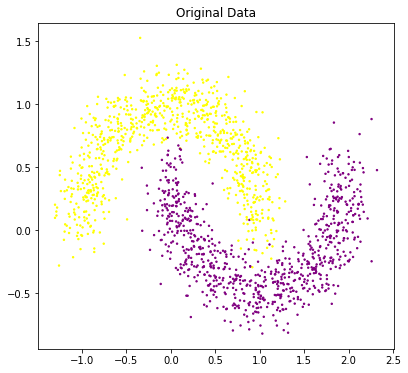

In [121]:
colors = ['yellow','purple']

fig = plt.figure()
ax1 = fig.add_subplot(1,2,2)
ax1.scatter(data[:,0], data[:,1], c = label[0, :],
              cmap = matplotlib.colors.ListedColormap(colors), s = 2);

plt.title('Original Data')
# ax2 = fig.add_subplot(1,2,2)
# ax2.scatter(data_2d[:,0], data_2d[:,1],
#             cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
fig.set_size_inches(14,6)
plt.show()



# Embedded LLE and Spectral with neighbors = 45

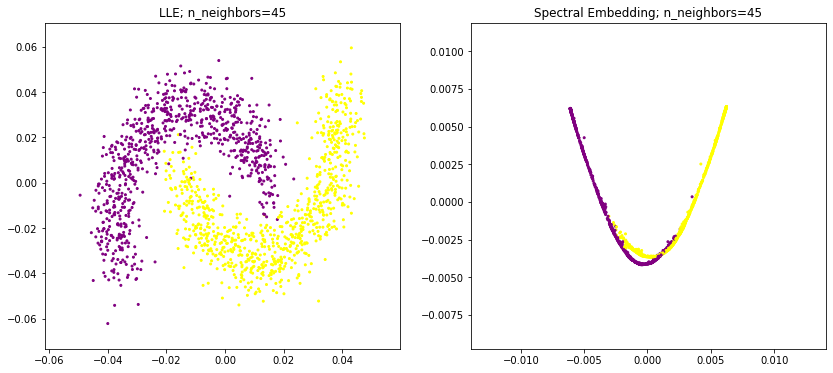

In [122]:
lle_nbrs = 45
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=lle_nbrs, random_state=23)
data_on_lle = lle.fit_transform(data)

se_nbrs = 45
se = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=se_nbrs)
data_on_se = se.fit_transform(data)


fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(data_on_lle[:,0], data_on_lle[:,1], c = label[0, :],
            cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
ax1.set_title('LLE; n_neighbors='+str(lle_nbrs))


ax2 = fig.add_subplot(1,2,2)
ax2.scatter(data_on_se[:,0], data_on_se[:,1],  c = label[0, :],
            cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
ax2.set_title('Spectral Embedding; n_neighbors='+str(se_nbrs))

fig.set_size_inches(14,6)
plt.show()

finding  45  neighbors for  1600  data


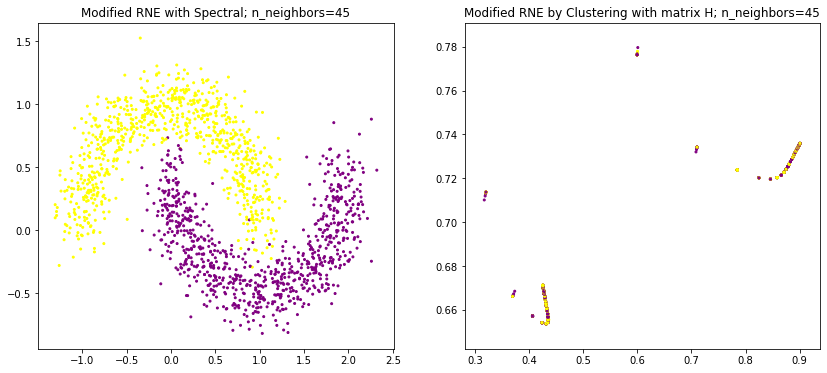

In [142]:
rne_nbrs1 = 45
rne1 = robust_neighbor_embedding_modified(data, n_neighbors=rne_nbrs1, out_dim=2, tol=1e-6, max_iter=200)
data_on_rne1 = rne1

rne_nbrs2 = 45
rne2 = robust_neighbor_embedding_modified_2(data, n_neighbors=rne_nbrs2, out_dim=2, tol=1e-6, max_iter=200)
data_on_rne2 = rne2

fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax1.scatter(data_on_rne1[:,0], data_on_rne1[:,1], c = label[0, :],
            cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
ax1.set_title('Modified RNE with Spectral; n_neighbors='+str(rne_nbrs1))


ax2 = fig.add_subplot(1,2,2)
ax2.scatter(data_on_rne2[:,0], data_on_rne2[:,1], c = label[0, :], 
            cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
ax2.set_title('Modified RNE by Clustering with matrix H; n_neighbors='+str(rne_nbrs2))

fig.set_size_inches(14,6)

plt.show()

finding  45  neighbors for  1600  data


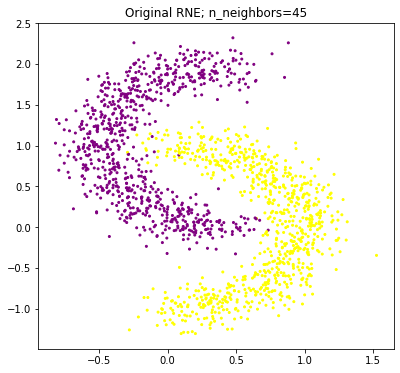

In [143]:
rne_nbrs = 45
rne = robust_neighbor_embedding(data, n_neighbors=rne_nbrs, out_dim=2, tol=1e-6, max_iter=200)
data_on_rne = rne


fig = plt.figure()

ax0 = fig.add_subplot(1,2,1)
ax0.scatter(data_on_rne[:,0], data_on_rne[:,1],c = label[0,:], 
            cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
ax0.set_title('Original RNE; n_neighbors='+str(rne_nbrs))


fig.set_size_inches(14,6)

plt.show()

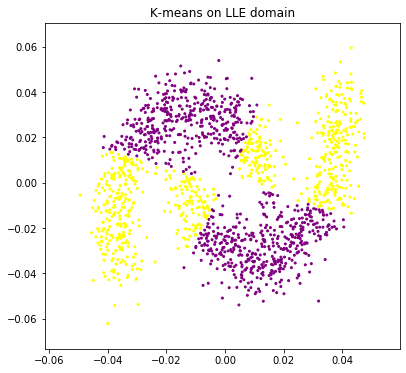

In [131]:
kmc_lle = KMeans(n_clusters=4, n_init=100, max_iter=300, tol=0.0001)
lle_clusters = kmc_lle.fit_predict(data_on_lle)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(data_on_lle[:,0], data_on_lle[:,1],c = lle_clusters, 
            cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
ax1.set_title('K-means on LLE domain')


fig.set_size_inches(14,6)
plt.show()

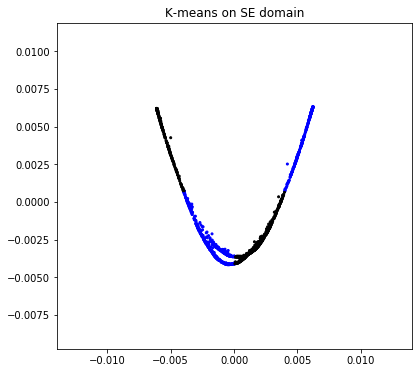

In [135]:
kmc_se = KMeans(n_clusters=4, n_init=100, max_iter=300, tol=0.0001)
se_clusters = kmc_se.fit_predict(data_on_se)

colors2 = ['blue','black']

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(data_on_se[:,0], data_on_se[:,1],c = se_clusters, 
            cmap = matplotlib.colors.ListedColormap(colors2), s = 4 )
ax1.set_title('K-means on SE domain')


fig.set_size_inches(14,6)
plt.show()

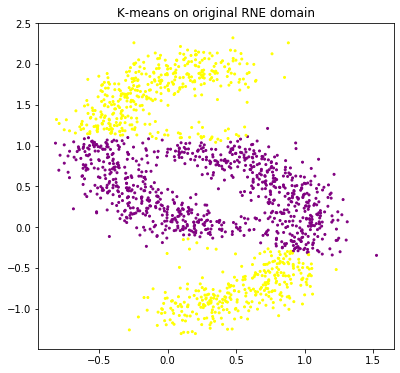

In [136]:
kmc_rne = KMeans(n_clusters=4, n_init=100, max_iter=300, tol=0.0001)
rne_clusters = kmc_rne.fit_predict(data_on_rne)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(data_on_rne[:,0], data_on_rne[:,1],c = rne_clusters, 
            cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
ax1.set_title('K-means on original RNE domain')

fig.set_size_inches(14,6)
plt.show()

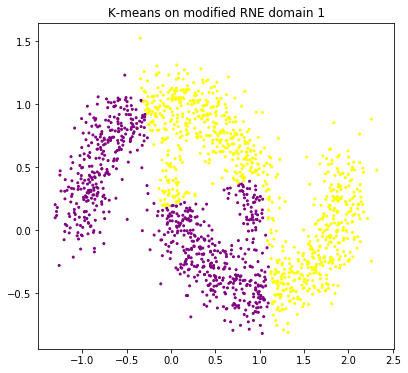

In [137]:
kmc_rne1 = KMeans(n_clusters=4, n_init=100, max_iter=300, tol=0.0001)
rne_clusters1 = kmc_rne1.fit_predict(data_on_rne1)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(data_on_rne1[:,0], data_on_rne1[:,1],c = rne_clusters1, 
            cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
ax1.set_title('K-means on modified RNE domain 1')

fig.set_size_inches(14,6)
plt.show()

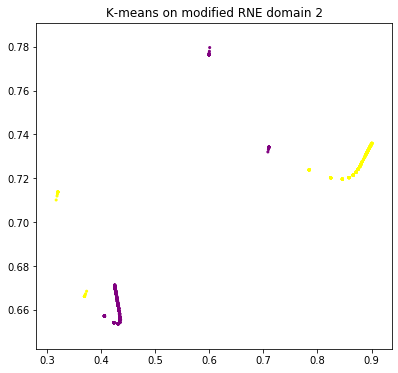

In [153]:
kmc_rne2 = KMeans(n_clusters=4, n_init=100, max_iter=300, tol=0.0001)
rne_clusters2 = kmc_rne.fit_predict(data_on_rne2)

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(data_on_rne2[:,0], data_on_rne2[:,1],c = rne_clusters2, 
            cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
ax1.set_title('K-means on modified RNE domain 2')


fig.set_size_inches(14,6)
plt.show()

In [ ]:
#for testing n_neighbors for LLE and Spectral Embedding

from sklearn.manifold import LocallyLinearEmbedding, SpectralEmbedding

matplotlib.use('Agg')
'''
for i in range(1,101):
    lle_nbrs =  i*5
    lle = LocallyLinearEmbedding(n_components=2, n_neighbors=lle_nbrs)
    data_on_lle = lle.fit_transform(data)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(data_on_lle[:,0], data_on_lle[:,1],c = label, 
               cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
    ax.set_title('LLE; n_neighbors='+str(lle_nbrs))
    filename = 'Figure'+'{0:04}'.format(lle_nbrs)+'.png'
    plt.savefig(filename)
plt.close('all')
'''
for i in range(1,31):

    rne_nbrs = i*5
    rne = robust_neighbor_embedding(data, n_neighbors=rne_nbrs, out_dim=2, tol=1e-6, max_iter=200)
    #se = SpectralEmbedding(n_components=2, affinity='rbf', n_neighbors=se_nbrs)
    #data_on_se = se.fit_transform(data)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(rne[:,0], rne[:,1],c = label, 
               cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
    ax.set_title('Original RNE; n_neighbors='+str(rne_nbrs))
    filename = 'Original RNE'+'{0:04}'.format(rne_nbrs)+'.png'
    plt.savefig(filename)
    
plt.close('all')



finding  5  neighbors for  1600  data
finding  10  neighbors for  1600  data
finding  15  neighbors for  1600  data
finding  20  neighbors for  1600  data
finding  25  neighbors for  1600  data
finding  30  neighbors for  1600  data
finding  35  neighbors for  1600  data
finding  40  neighbors for  1600  data
finding  45  neighbors for  1600  data
finding  50  neighbors for  1600  data
finding  55  neighbors for  1600  data
finding  60  neighbors for  1600  data
finding  65  neighbors for  1600  data


In [ ]:
#for testing n_neighbors for LLE and Spectral Embedding

from sklearn.manifold import LocallyLinearEmbedding, SpectralEmbedding

matplotlib.use('Agg')
'''
for i in range(1,101):
    lle_nbrs =  i*5
    lle = LocallyLinearEmbedding(n_components=2, n_neighbors=lle_nbrs)
    data_on_lle = lle.fit_transform(data)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(data_on_lle[:,0], data_on_lle[:,1],c = label, 
               cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
    ax.set_title('LLE; n_neighbors='+str(lle_nbrs))
    filename = 'Figure'+'{0:04}'.format(lle_nbrs)+'.png'
    plt.savefig(filename)
plt.close('all')
'''
for i in range(5,31):

    rne_nbrs = i*10
    rne = robust_neighbor_embedding_modified(data, n_neighbors=rne_nbrs, out_dim=2, tol=1e-6, max_iter=200)
    #se = SpectralEmbedding(n_components=2, affinity='rbf', n_neighbors=se_nbrs)
    #data_on_se = se.fit_transform(data)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(rne[:,0], rne[:,1],c = label, 
               cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
    ax.set_title('modified RNE 1; n_neighbors='+str(rne_nbrs))
    filename = 'modified RNE 1'+'{0:04}'.format(rne_nbrs)+'.png'
    plt.savefig(filename)
    
plt.close('all')




In [ ]:
#for testing n_neighbors for LLE and Spectral Embedding

from sklearn.manifold import LocallyLinearEmbedding, SpectralEmbedding

matplotlib.use('Agg')
'''
for i in range(1,101):
    lle_nbrs =  i*5
    lle = LocallyLinearEmbedding(n_components=2, n_neighbors=lle_nbrs)
    data_on_lle = lle.fit_transform(data)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(data_on_lle[:,0], data_on_lle[:,1],c = label, 
               cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
    ax.set_title('LLE; n_neighbors='+str(lle_nbrs))
    filename = 'Figure'+'{0:04}'.format(lle_nbrs)+'.png'
    plt.savefig(filename)
plt.close('all')
'''
for i in range(5,31):

    rne_nbrs = i*10
    rne = robust_neighbor_embedding_modified_2(data, n_neighbors=rne_nbrs, out_dim=2, tol=1e-6, max_iter=200)
    #se = SpectralEmbedding(n_components=2, affinity='rbf', n_neighbors=se_nbrs)
    #data_on_se = se.fit_transform(data)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.scatter(rne[:,0], rne[:,1],c = label, 
               cmap = matplotlib.colors.ListedColormap(colors), s = 4 )
    ax.set_title('modified RNE 2; n_neighbors='+str(rne_nbrs))
    filename = 'modified RNE 2'+'{0:04}'.format(rne_nbrs)+'.png'
    plt.savefig(filename)
    
plt.close('all')





In [145]:
rne4 = robust_neighbor_embedding(data, 4, 2, tol=1e-6, max_iter=200)
rne6 = robust_neighbor_embedding(data, 6, 2, tol=1e-6, max_iter=200)
rne8 = robust_neighbor_embedding(data, 8, 2, tol=1e-6, max_iter=200)
rne10 = robust_neighbor_embedding(data, 10, 2, tol=1e-6, max_iter=200)
rne12 = robust_neighbor_embedding(data, 12, 2, tol=1e-6, max_iter=200)
rne14 = robust_neighbor_embedding(data, 14, 2, tol=1e-6, max_iter=200)
rne16 = robust_neighbor_embedding(data, 16, 2, tol=1e-6, max_iter=200)
rne18 = robust_neighbor_embedding(data, 18, 2, tol=1e-6, max_iter=200)




finding  4  neighbors for  1600  data
finding  6  neighbors for  1600  data
finding  8  neighbors for  1600  data
finding  10  neighbors for  1600  data
finding  12  neighbors for  1600  data
finding  14  neighbors for  1600  data
finding  16  neighbors for  1600  data
finding  18  neighbors for  1600  data


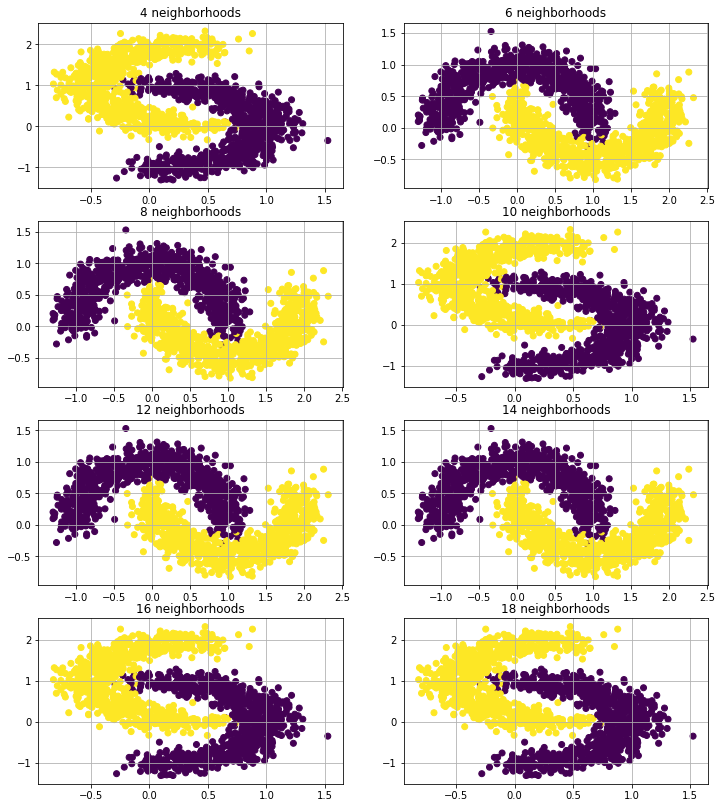

In [147]:
plt.figure(figsize=(12,14))

plt.subplot(4,2,1)
plt.title('4 neighborhoods')
plt.scatter(rne4[:, 0], rne4[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,2)
plt.title('6 neighborhoods')
plt.scatter(rne6[:, 0], rne6[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,3)
plt.title('8 neighborhoods')
plt.scatter(rne8[:, 0], rne8[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,4)
plt.title('10 neighborhoods')
plt.scatter(rne10[:, 0], rne10[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,5)
plt.title('12 neighborhoods')
plt.scatter(rne12[:, 0], rne12[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,6)
plt.title('14 neighborhoods')
plt.scatter(rne14[:, 0], rne14[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,7)
plt.title('16 neighborhoods')
plt.scatter(rne16[:, 0], rne16[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,8)
plt.title('18 neighborhoods')
plt.scatter(rne18[:, 0], rne18[:, 1], c=label[0, :])
plt.grid(True)

plt.show()

In [149]:
mrne4 = robust_neighbor_embedding_modified(data, 4, 2, tol=1e-6, max_iter=200)
mrne6 = robust_neighbor_embedding_modified(data, 6, 2, tol=1e-6, max_iter=200)
mrne8 = robust_neighbor_embedding_modified(data, 8, 2, tol=1e-6, max_iter=200)
mrne10 = robust_neighbor_embedding_modified(data, 10, 2, tol=1e-6, max_iter=200)
mrne12 = robust_neighbor_embedding_modified(data, 12, 2, tol=1e-6, max_iter=200)
mrne14 = robust_neighbor_embedding_modified(data, 14, 2, tol=1e-6, max_iter=200)
mrne16 = robust_neighbor_embedding_modified(data, 16, 2, tol=1e-6, max_iter=200)
mrne18 = robust_neighbor_embedding_modified(data, 18, 2, tol=1e-6, max_iter=200)




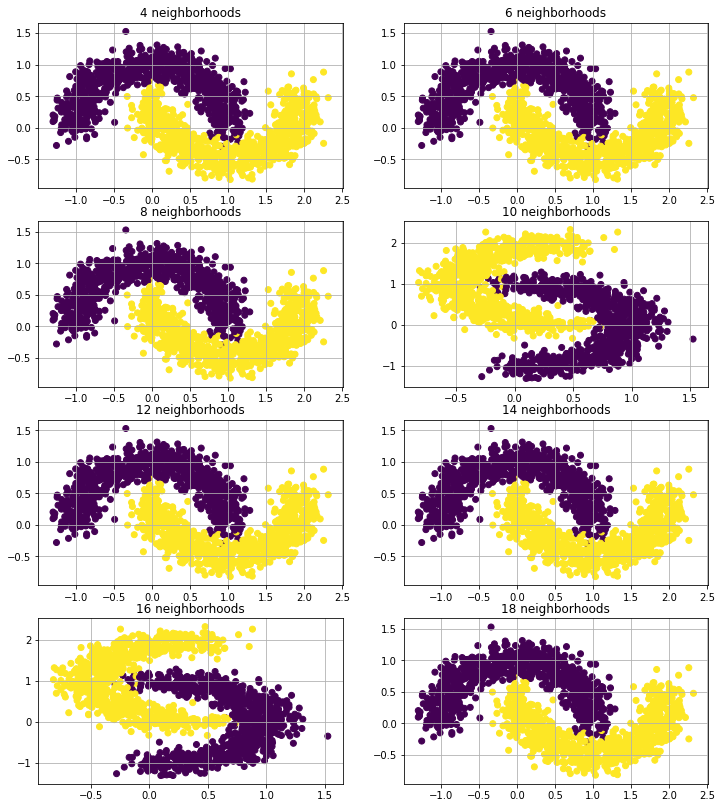

In [150]:
plt.figure(figsize=(12,14))

plt.subplot(4,2,1)
plt.title('4 neighborhoods')
plt.scatter(mrne4[:, 0], mrne4[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,2)
plt.title('6 neighborhoods')
plt.scatter(mrne6[:, 0], mrne6[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,3)
plt.title('8 neighborhoods')
plt.scatter(mrne8[:, 0], mrne8[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,4)
plt.title('10 neighborhoods')
plt.scatter(mrne10[:, 0], mrne10[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,5)
plt.title('12 neighborhoods')
plt.scatter(mrne12[:, 0], mrne12[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,6)
plt.title('14 neighborhoods')
plt.scatter(mrne14[:, 0], mrne14[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,7)
plt.title('16 neighborhoods')
plt.scatter(mrne16[:, 0], mrne16[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,8)
plt.title('18 neighborhoods')
plt.scatter(mrne18[:, 0], mrne18[:, 1], c=label[0, :])
plt.grid(True)

plt.show()

In [151]:
m2rne4 = robust_neighbor_embedding_modified_2(data, 4, 2, tol=1e-6, max_iter=200)
m2rne6 = robust_neighbor_embedding_modified_2(data, 6, 2, tol=1e-6, max_iter=200)
m2rne8 = robust_neighbor_embedding_modified_2(data, 8, 2, tol=1e-6, max_iter=200)
m2rne10 = robust_neighbor_embedding_modified_2(data, 10, 2, tol=1e-6, max_iter=200)
m2rne12 = robust_neighbor_embedding_modified_2(data, 12, 2, tol=1e-6, max_iter=200)
m2rne14 = robust_neighbor_embedding_modified_2(data, 14, 2, tol=1e-6, max_iter=200)
m2rne16 = robust_neighbor_embedding_modified_2(data, 16, 2, tol=1e-6, max_iter=200)
m2rne18 = robust_neighbor_embedding_modified_2(data, 18, 2, tol=1e-6, max_iter=200)





finding  45  neighbors for  1600  data
finding  45  neighbors for  1600  data
finding  45  neighbors for  1600  data
finding  45  neighbors for  1600  data
finding  45  neighbors for  1600  data
finding  45  neighbors for  1600  data
finding  45  neighbors for  1600  data
finding  45  neighbors for  1600  data


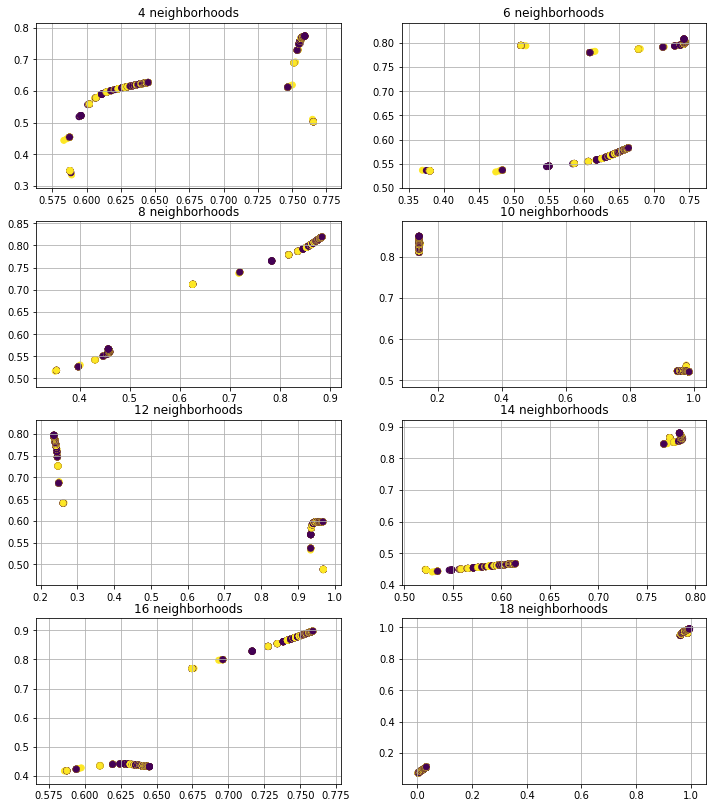

In [152]:
plt.figure(figsize=(12,14))

plt.subplot(4,2,1)
plt.title('4 neighborhoods')
plt.scatter(m2rne4[:, 0], m2rne4[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,2)
plt.title('6 neighborhoods')
plt.scatter(m2rne6[:, 0], m2rne6[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,3)
plt.title('8 neighborhoods')
plt.scatter(m2rne8[:, 0], m2rne8[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,4)
plt.title('10 neighborhoods')
plt.scatter(m2rne10[:, 0], m2rne10[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,5)
plt.title('12 neighborhoods')
plt.scatter(m2rne12[:, 0], m2rne12[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,6)
plt.title('14 neighborhoods')
plt.scatter(m2rne14[:, 0], m2rne14[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,7)
plt.title('16 neighborhoods')
plt.scatter(m2rne16[:, 0], m2rne16[:, 1], c=label[0, :])
plt.grid(True)

plt.subplot(4,2,8)
plt.title('18 neighborhoods')
plt.scatter(m2rne18[:, 0], m2rne18[:, 1], c=label[0, :])
plt.grid(True)

plt.show()